<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">pyGROWAT1D</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);"><b style=color:red;>GRO</b>und<b style=color:red;>WAT</b>er</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
<td><img style="height: 150px;" src="images/pyGROWAT1D.png"></td>
</tr>
</table>

----
# `pyGROWAT1D`

GROundWATer1D, a program package for  flow in porous rocks.

# Finite differences 
## Diffusion equation in 1D
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

----
In this notebook, we solve a simple **transient advection equation** in one dimension,
using different numerical methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The general advection-diffusion-reacton equation reads:
$$\fbox{$
\frac{\partial c}{\partial t}
= - v \cdot \nabla c
+ \nabla D \nabla c
+ R
$}$$
with
$c$ [mol/m$^3$] concentration,
$x,y,z$ [m] position,
$t$ [s] time,
$v$ [m/s] the velocity, 
$D$ [m$^2$/s] diffusion, 
$R$ [mol/m$^3$/s] reaction,
$\nabla$ [1/m] Nabla operator.

The term on the left-hand side is the temporal change of $c$,
the terms on the right-hand sides are
- advection
- diffusion
- reaction

----
## Diffusion

We start defining the transient diffusion equation for the concentration $c(x,t)$:
$$
\fbox{$
\frac{\partial c(x,t)}{\partial t} - D \frac{d^2c}{dx^2} = 0
$}
$$

The transient diffusion equation is a **hyperbolic partial differential equation**, which has a unique
solution for the **initial condition**:
$$
c(x,t=0) = c_0(x,0)
$$

----
## Initial condition

We define the `Gaussian` function with mean $\mu$ and standard deviation $\sigma$
as initial condition:
$$
c(x) = e^{-\frac{(x-\mu)^2}{\sigma^2}}
$$
which is a solution of the transient advection equation.

In [2]:
def pulse(x,mu=2.,sigma=1.,type='gauss'):
    """
    Initial pulse function centered at mu and having standard with sigma
    """
    if (type=='gauss'): 
        f = np.exp(-(x-mu)**2/(sigma)**2)
    if (type=='rect'):
        f = np.zeros_like(x)
        f[(x >= mu-sigma) & (x <= mu+sigma)] = 1
    return f

In [3]:
xstep = 121
x,dx = np.linspace(0,12,xstep,retstep=True)   # m
print(dx)

0.1


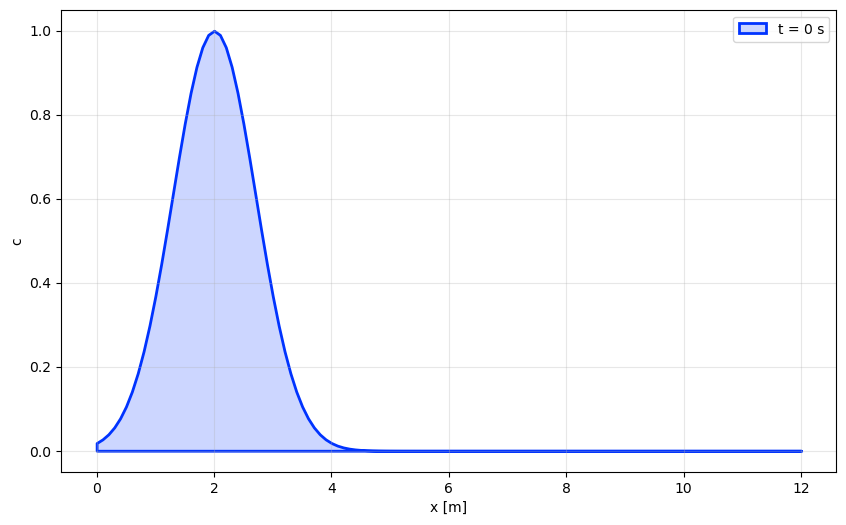

In [4]:
c0 = pulse(x)

plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.fill_between(x,c0,0,label='t = 0 s',linewidth=2,edgecolor=(0,0.2,1,1.0), facecolor=(0,0.2,1,.2))
plt.legend()

----
## Numerical solution methods

Next, we derive several numerical methods, which can be used to solve the transient diffusion equation.
We first need to assign the temporal and spatial time steps, $\Delta t$ [s] and $\Delta x$ [m], 
and the velocity $c$ [m/s]:

Thus we have discretised both spatial and temporal variables:
$$
\begin{array}{rcl}
t_n &=& t_0 + n \Delta t, \quad n=0,N \\
x_i &=& x_0 + i \Delta x, \quad i=0,I
\end{array}
$$

The **diffusive Courant-Friedrich-Levi criterion**, also called *diffusive Courant number*, is defined as
$$
Co^d = \frac{D \Delta t}{\Delta x^2}
$$
defines the stability of the numerical solutions. Explicit solutions are stable
for $Co^d <1$.

We solve for the time increment:
$$
\Delta t < \frac{\Delta x^2}{D}
$$

For a given velocity $D$, the time steps can  be defined:

In [5]:
v  = 0.0   # m/s
D  = 0.3   # m2/s

dtDiff = dx**2/D
print ('Courant time step: ',dtDiff)
safety = 0.2
dtDiff *= safety
print ('Courant time step with safety margin: ',dtDiff)

Courant time step:  0.03333333333333334
Courant time step with safety margin:  0.006666666666666668


In [6]:
timeStart = 0.
timeEnd   = 5.
timeStep  = dtDiff
timeWrite = 1.

----
## FTCS scheme (forward time centered space)

Our first scheme is called `FTCS`, forward time, centered space, thus the derivatives in the
transient advection equations are replaced by **forward differences in time** and 
**central differences is space**:
$$
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t}
=
D \frac{c_{i+1}^{n}-2 c_{i}^{n} + c_{i-1}^{n}}{\Delta x^2}
$$
or solved for the next time step
$$
c_{i}^{n+1}
=
\left( 1-2\alpha \right) c_{i}^{n} 
+ \alpha \left( c_{i+1}^{n} + c_{i-1}^{n} \right)
$$
with
$$
\alpha = D \frac{\Delta t}{\Delta x^2}
$$
<img src="images/PDE_FTCS.jpg" style="height:5cm;">

We implement the FTCS method:

In [7]:
def FD_Diffusion1D(c,dx,dt,D):
    """
    1D diffusion operator
    FTCS forward time centered space
    """
    nx = c.shape[0]
    cold = c
    alpha = D*dt/(dx**2)
    for i in range(nx):
        if (i != 0 and i != nx-1):
            c[i] = (1-2*alpha)*cold[i] + alpha*(cold[i+1]+cold[i-1])
        else:
            c[i] = cold[i]
    return c

In [9]:
# initial conditions
time = timeStart
c    = pulse(x,mu=6)
c0  = np.copy(c)

# time loop
while (time < timeEnd):
    time += timeStep
    c = FD_Diffusion1D(c,dx,timeStep,D)

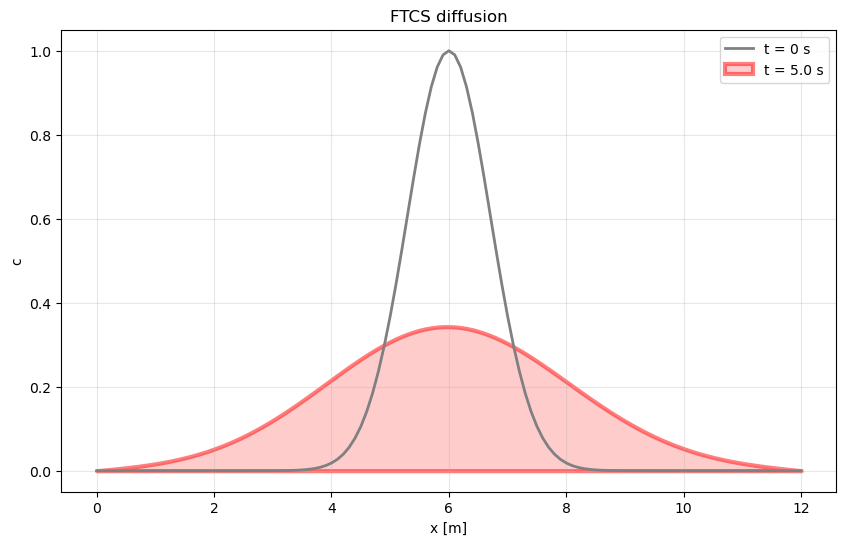

In [10]:
# plot initial condition and last time step
plt.figure(figsize=(10,6))
plt.title('FTCS diffusion')
plt.xlabel('x [m]')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.plot(x,c0,label='t = 0 s',linewidth=2,color=(0.5,0.5,0.5,1.0))
plt.fill_between(x,c,lw=3,edgecolor=(1,0,0,0.5), facecolor=(1,0,0,0.2),label='t = '+str(round(time,1))+' s')
plt.legend()

----